#### Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Any
import sys
import os
import time
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [2]:
# # Add parent directory to path to import the cache modules
# sys.path.append('../')  # Adjust if needed to point to your parent folder

In [3]:
# Import the cache implementations
from hf_cache import KNormCache
from leverage_scores_cache import SLSCache, LevScoreKVCache

In [4]:
# # Set random seed for reproducibility
# torch.manual_seed(42)
# np.random.seed(42)

In [5]:
def generate_synthetic_kv_data(
    batch_size: int = 1,
    num_heads: int = 4,
    seq_len: int = 1000,
    head_dim: int = 64,
    correlation: float = 0.5
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Generate synthetic key, value, and query data with controlled properties.
    """
    # Create a base matrix that introduces correlation between tokens
    base_k = torch.randn(batch_size, num_heads, 1, head_dim)
    base_v = torch.randn(batch_size, num_heads, 1, head_dim)
    
    # Generate individual token vectors with correlation to the base
    rand_k = torch.randn(batch_size, num_heads, seq_len, head_dim)
    keys = correlation * base_k + (1 - correlation) * rand_k
    
    rand_v = torch.randn(batch_size, num_heads, seq_len, head_dim)
    values = correlation * base_v + (1 - correlation) * rand_v
    
    # Generate a query vector
    query = torch.randn(batch_size, num_heads, 1, head_dim)
    
    # Normalize vectors for stability
    keys = keys / torch.norm(keys, dim=-1, keepdim=True)
    values = values / torch.norm(values, dim=-1, keepdim=True)
    query = query / torch.norm(query, dim=-1, keepdim=True)
    
    return keys, values, query

In [6]:
def compute_attention_output(
    query: torch.Tensor,
    keys: torch.Tensor,
    values: torch.Tensor
) -> torch.Tensor:
    """
    Compute attention output for given query, keys, and values.
    """
    # Compute attention weights
    dk = keys.shape[-1]
    scores = torch.matmul(query, keys.transpose(-1, -2)) / (dk ** 0.5)
    attention = torch.softmax(scores, dim=-1)
    
    # Apply attention to values
    output = torch.matmul(attention, values)
    
    return output

In [7]:
def compute_distortion(
    original_output: torch.Tensor,
    compressed_output: torch.Tensor
) -> float:
    """
    Compute distortion between original and compressed outputs.
    """
    return torch.norm(original_output - compressed_output).item()

In [8]:
def evaluate_compression_method(
    cache_class,
    keys: torch.Tensor,
    values: torch.Tensor,
    query: torch.Tensor,
    window_length: int,
    max_length: int,
    cache_kwargs: Optional[Dict[str, Any]] = None
) -> Tuple[float, float]:
    """
    Evaluate a compression method by comparing original and compressed outputs.
    """
    # Initialize cache
    if cache_kwargs is None:
        cache_kwargs = {}
    
    cache = cache_class(max_length=max_length, window_length=window_length, **cache_kwargs)
    
    # Add to cache and measure time
    start_time = time.time()
    cache.update(keys, values, layer_idx=0, cache_kwargs={'query': query})
    time_taken = time.time() - start_time
    
    # Get compressed cache
    compressed_keys, compressed_values = cache.key_cache[0], cache.value_cache[0]
    
    # Compute original output
    original_output = compute_attention_output(query, keys, values)
    
    # Compute compressed output
    compressed_output = compute_attention_output(query, compressed_keys, compressed_values)
    
    # Compute distortion
    distortion = compute_distortion(original_output, compressed_output)
    
    return distortion, time_taken

In [9]:
def load_real_kv_caches(model_name='gpt2', seq_len=1000, device='cpu'):
    """
    Load real KV caches from a pre-trained transformer model.
    
    Args:
        model_name: Name of the model to load
        seq_len: Sequence length to generate
        device: Device to run the model on ('cpu' or 'cuda')
        
    Returns:
        keys, values, query: Real KV caches and query
        model_info: Dictionary with model information
    """
    try:
        from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
        
        print(f"Loading model: {model_name} with sequence length: {seq_len}")
        
        # Load model config first to get architecture information
        config = AutoConfig.from_pretrained(model_name)
        
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        if not tokenizer.pad_token:
            tokenizer.pad_token = tokenizer.eos_token
            
        model = AutoModelForCausalLM.from_pretrained(model_name)
        model = model.to(device)
        model.eval()
        
        # Collect model information
        model_info = {
            'name': model_name,
            'num_layers': getattr(config, 'num_hidden_layers', 
                                getattr(config, 'n_layer', 
                                      getattr(config, 'num_layers', 12))),
            'num_heads': getattr(config, 'num_attention_heads', 
                               getattr(config, 'n_head', 12)),
            'hidden_size': getattr(config, 'hidden_size', 
                                getattr(config, 'd_model', 
                                      getattr(config, 'n_embd', 768))),
            'architecture': config.model_type
        }
        
        # Generate random text or use a fixed prompt
        text = "The quick brown fox jumps over the lazy dog. This is a sample text to generate key-value caches for evaluation of compression methods."
        # Repeat the text to reach the desired sequence length
        while len(tokenizer.encode(text)) < seq_len:
            text = text + " " + text
            
        # Tokenize and truncate to desired length
        inputs = tokenizer(text, return_tensors="pt", padding="max_length", max_length=seq_len, truncation=True)
        inputs = inputs.to(device)
        
        # Forward pass to get KV caches
        with torch.no_grad():
            outputs = model(**inputs, use_cache=True)
            
        # Extract past key values
        past_key_values = outputs.past_key_values
        
        # Extract the last layer's KV cache
        layer_idx = -1  # Last layer
        
        if model_info['architecture'] in ['gpt2', 'gpt_neo', 'bloom', 'llama', 'mistral']:
            # These models typically use (batch, heads, seq_len, head_dim) format
            keys = past_key_values[layer_idx][0]
            values = past_key_values[layer_idx][1]
            
            # Generate a query from the model's embedding of the last token
            last_token = inputs.input_ids[:, -1:]
            
            # Different models have different ways to get queries
            if hasattr(model, 'get_input_embeddings'):
                last_token_embedding = model.get_input_embeddings()(last_token)
                
                # Find the attention module to generate query
                if hasattr(model, 'transformer'):
                    if hasattr(model.transformer, 'h'):
                        # GPT-2 style
                        query_module = model.transformer.h[0].attn.c_attn
                    elif hasattr(model.transformer, 'layers'):
                        # Some other architectures
                        query_module = model.transformer.layers[0].self_attn.q_proj
                elif hasattr(model, 'model'):
                    if hasattr(model.model, 'layers'):
                        # LLaMA style
                        query_module = model.model.layers[0].self_attn.q_proj
                        
                # If we found a query module, use it
                if 'query_module' in locals():
                    query = query_module(last_token_embedding)
                    
                    # Reshape based on model architecture
                    if model_info['architecture'] == 'gpt2':
                        # GPT-2 has combined QKV
                        query_parts = torch.split(query, model_info['hidden_size'], dim=-1)
                        query = query_parts[0].view(1, model_info['num_heads'], 1, model_info['hidden_size'] // model_info['num_heads'])
                    else:
                        # Other models might have separate Q projection
                        head_dim = model_info['hidden_size'] // model_info['num_heads']
                        query = query.view(1, model_info['num_heads'], 1, head_dim)
                else:
                    # If we couldn't find the right module, generate a random query
                    head_dim = keys.shape[-1]
                    query = torch.randn(1, model_info['num_heads'], 1, head_dim, device=device)
                    query = query / torch.norm(query, dim=-1, keepdim=True)
            else:
                # Fallback to random query
                head_dim = keys.shape[-1]
                query = torch.randn(1, model_info['num_heads'], 1, head_dim, device=device)
                query = query / torch.norm(query, dim=-1, keepdim=True)
        else:
            # For other architectures, we might need different extraction logic
            # This is a simplification for demonstration
            print(f"Unsupported model architecture: {model_info['architecture']}. Using synthetic query.")
            
            # Try to extract in the most common format
            if isinstance(past_key_values[layer_idx], tuple) and len(past_key_values[layer_idx]) >= 2:
                keys = past_key_values[layer_idx][0]
                values = past_key_values[layer_idx][1]
            else:
                print("Could not extract keys and values. Generating synthetic data.")
                return None, None, None, None
            
            # Generate a random query with matching dimensions
            head_dim = keys.shape[-1]
            query = torch.randn(1, model_info['num_heads'], 1, head_dim, device=device)
            query = query / torch.norm(query, dim=-1, keepdim=True)
        
        # Move to CPU if needed to save GPU memory
        if device != 'cpu':
            keys = keys.cpu()
            values = values.cpu()
            query = query.cpu()
            
        return keys, values, query, model_info
    
    except ImportError:
        print("Transformers library not found. Using synthetic data instead.")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading model {model_name}: {e}")
        return None, None, None, None

In [10]:
# New function to evaluate across both sequence lengths and compression ratios
def evaluate_sequence_length_and_compression(
    models=['gpt2'],
    seq_lengths=[256, 512, 1024, 2048],
    compression_ratios=[0.2, 0.4, 0.6, 0.8, 1.0],
    window_ratio=0.2,
    use_real_models=True
):
    """
    Evaluate compression methods across both sequence lengths and compression ratios.
    
    Args:
        models: List of model names to evaluate
        seq_lengths: List of sequence lengths to test
        compression_ratios: List of compression ratios to evaluate
        window_ratio: Ratio of window length to sequence length
        use_real_models: Whether to use real models or synthetic data
    """
    # Check for GPU availability
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Define methods to compare
    methods = {
        'KNorm': KNormCache,
        'SLS': SLSCache,
        'LevScoreKV': LevScoreKVCache
    }
    
    # Initialize results containers
    all_results = {}
    all_times = {}
    
    # For each model
    for model_name in models:
        print(f"\n===== Evaluating model: {model_name} =====")
        
        model_results = {method: {} for method in methods}
        model_times = {method: {} for method in methods}
        
        # For each sequence length
        for seq_len in seq_lengths:
            print(f"\nTesting sequence length: {seq_len}")
            
            # Load model or generate synthetic data
            if use_real_models:
                keys, values, query, model_info = load_real_kv_caches(model_name, seq_len, device)
                
                # If loading failed, use synthetic data
                if keys is None:
                    print(f"Using synthetic data for {model_name} at sequence length {seq_len}")
                    batch_size = 1
                    num_heads = 4  # Default, adjust based on model if needed
                    head_dim = 64   # Default, adjust based on model if needed
                    keys, values, query = generate_synthetic_kv_data(
                        batch_size=batch_size,
                        num_heads=num_heads,
                        seq_len=seq_len,
                        head_dim=head_dim,
                        correlation=0.5
                    )
            else:
                print(f"Using synthetic data for sequence length {seq_len}")
                batch_size = 1
                num_heads = 4
                head_dim = 64
                keys, values, query = generate_synthetic_kv_data(
                    batch_size=batch_size,
                    num_heads=num_heads,
                    seq_len=seq_len,
                    head_dim=head_dim,
                    correlation=0.5
                )
            
            # Define window length
            window_length = int(seq_len * window_ratio)
            
            # Initialize results for this sequence length
            for method in methods:
                model_results[method][seq_len] = []
                model_times[method][seq_len] = []
            
            # For each compression ratio
            for alpha in tqdm(compression_ratios, desc=f"Testing compression ratios for seq_len={seq_len}"):
                max_length = int(seq_len * alpha)
                
                # Skip if max_length is too small
                if max_length <= window_length:
                    for method in methods:
                        model_results[method][seq_len].append(float('nan'))
                        model_times[method][seq_len].append(float('nan'))
                    continue
                
                # Evaluate each method
                for name, method_class in methods.items():
                    # Create method-specific kwargs
                    if name == 'LevScoreKV':
                        kwargs = {'beta': 0.5, 'gamma': 1.0, 'n_samples': 10}
                    elif name == 'SLS':
                        kwargs = {'lambda_weight': 0.5, 'n_samples': 10}
                    else:
                        kwargs = {}
                    
                    # Evaluate the method
                    try:
                        distortion, time_taken = evaluate_compression_method(
                            method_class,
                            keys,
                            values,
                            query,
                            window_length,
                            max_length,
                            cache_kwargs=kwargs
                        )
                        
                        # Store results
                        model_results[name][seq_len].append(distortion)
                        model_times[name][seq_len].append(time_taken)
                        
                    except Exception as e:
                        print(f"Error evaluating {name} at seq_len={seq_len}, alpha={alpha}: {e}")
                        model_results[name][seq_len].append(float('nan'))
                        model_times[name][seq_len].append(float('nan'))
        
        # Store results for this model
        all_results[model_name] = model_results
        all_times[model_name] = model_times
        
        # Visualize results for this model
        plot_sequence_compression_heatmaps(model_name, model_results, model_times, seq_lengths, compression_ratios)
        
    return all_results, all_times, seq_lengths, compression_ratios

In [11]:
def plot_sequence_compression_heatmaps(
    model_name: str,
    results: Dict[str, Dict[int, List[float]]],
    times: Dict[str, Dict[int, List[float]]],
    seq_lengths: List[int],
    compression_ratios: List[float]
):
    """
    Plot heatmaps of distortion and time vs sequence length and compression ratio.
    """
    # Create figure with subplots for each method (distortion)
    n_methods = len(results)
    fig, axs = plt.subplots(1, n_methods, figsize=(6 * n_methods, 5))
    
    # If only one method, make axs a list for consistent indexing
    if n_methods == 1:
        axs = [axs]
    
    # For each method, create a heatmap of distortion
    for i, (method, seq_results) in enumerate(results.items()):
        # Convert to numpy array
        data = np.zeros((len(seq_lengths), len(compression_ratios)))
        
        for j, seq_len in enumerate(seq_lengths):
            for k, alpha in enumerate(compression_ratios):
                if k < len(seq_results[seq_len]):
                    data[j, k] = seq_results[seq_len][k]
                else:
                    data[j, k] = np.nan
        
        # Create heatmap
        im = axs[i].imshow(
            data, 
            cmap='viridis_r',  # Reversed viridis (lower values = better = green)
            aspect='auto',
            extent=[min(compression_ratios), max(compression_ratios), max(seq_lengths), min(seq_lengths)]
        )
        
        # Add labels
        axs[i].set_xlabel('Compression Ratio (α)')
        if i == 0:
            axs[i].set_ylabel('Sequence Length')
        axs[i].set_title(f'{method} - Distortion')
        
        # Add colorbar
        plt.colorbar(im, ax=axs[i], label='Distortion')
        
        # Add sequence length labels
        axs[i].set_yticks(seq_lengths)
        axs[i].set_yticklabels(seq_lengths)
        
        # Add compression ratio labels
        axs[i].set_xticks(compression_ratios)
        axs[i].set_xticklabels([f'{cr:.1f}' for cr in compression_ratios])
    
    plt.suptitle(f'Distortion vs. Sequence Length and Compression Ratio - {model_name}')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    # Create figure with subplots for each method (computation time)
    fig, axs = plt.subplots(1, n_methods, figsize=(6 * n_methods, 5))
    
    # If only one method, make axs a list for consistent indexing
    if n_methods == 1:
        axs = [axs]
    
    # For each method, create a heatmap of computation time
    for i, (method, seq_times) in enumerate(times.items()):
        # Convert to numpy array
        data = np.zeros((len(seq_lengths), len(compression_ratios)))
        
        for j, seq_len in enumerate(seq_lengths):
            for k, alpha in enumerate(compression_ratios):
                if k < len(seq_times[seq_len]):
                    data[j, k] = seq_times[seq_len][k]
                else:
                    data[j, k] = np.nan
        
        # Create heatmap
        im = axs[i].imshow(
            data, 
            cmap='inferno_r',  # Reversed inferno (lower values = better = yellow)
            aspect='auto',
            extent=[min(compression_ratios), max(compression_ratios), max(seq_lengths), min(seq_lengths)]
        )
        
        # Add labels
        axs[i].set_xlabel('Compression Ratio (α)')
        if i == 0:
            axs[i].set_ylabel('Sequence Length')
        axs[i].set_title(f'{method} - Computation Time')
        
        # Add colorbar
        plt.colorbar(im, ax=axs[i], label='Time (s)')
        
        # Add sequence length labels
        axs[i].set_yticks(seq_lengths)
        axs[i].set_yticklabels(seq_lengths)
        
        # Add compression ratio labels
        axs[i].set_xticks(compression_ratios)
        axs[i].set_xticklabels([f'{cr:.1f}' for cr in compression_ratios])
    
    plt.suptitle(f'Computation Time vs. Sequence Length and Compression Ratio - {model_name}')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [12]:
def create_sequence_compression_line_plots(
    model_name: str,
    results: Dict[str, Dict[int, List[float]]],
    seq_lengths: List[int],
    compression_ratios: List[float]
):
    """
    Create line plots showing how distortion changes with sequence length for different compression ratios.
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define line styles for methods
    method_styles = {
        'KNorm': {'color': 'blue', 'marker': 'o'},
        'SLS': {'color': 'green', 'marker': 's'},
        'LevScoreKV': {'color': 'red', 'marker': '^'}
    }
    
    # Choose a middle compression ratio to focus on
    # focus_alpha_idx = len(compression_ratios) // 2
    focus_alpha_idx = 0
    focus_alpha = compression_ratios[focus_alpha_idx]
    
    # For each method, plot distortion vs sequence length
    for method, seq_results in results.items():
        # Extract distortion at the focus compression ratio for each sequence length
        distortions = []
        for seq_len in seq_lengths:
            if focus_alpha_idx < len(seq_results[seq_len]):
                distortions.append(seq_results[seq_len][focus_alpha_idx])
            else:
                distortions.append(float('nan'))
        
        # Plot line
        ax.plot(
            seq_lengths, 
            distortions, 
            label=f'{method} (α={focus_alpha:.1f})',
            **method_styles[method]
        )
    
    # Add labels and legend
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Distortion')
    ax.set_title(f'Distortion vs. Sequence Length at α={focus_alpha:.1f} - {model_name}')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set x-axis to log scale to better visualize different sequence lengths
    ax.set_xscale('log', base=2)
    ax.set_xticks(seq_lengths)
    ax.set_xticklabels(seq_lengths)
    
    plt.tight_layout()
    plt.show()
    
    # Create figure for distortion vs compression ratio for different sequence lengths
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define line styles for sequence lengths
    seq_styles = {
        seq_lengths[0]: {'color': 'purple', 'marker': 'o', 'linestyle': '-'},
        seq_lengths[-1]: {'color': 'orange', 'marker': 's', 'linestyle': '--'}
    }
    
    # Choose a method to focus on (e.g., LevScoreKV)
    focus_method = 'LevScoreKV'
    
    # For shortest and longest sequence length, plot distortion vs compression ratio
    for seq_len in [seq_lengths[0], seq_lengths[-1]]:
        if seq_len in results[focus_method]:
            ax.plot(
                compression_ratios[:len(results[focus_method][seq_len])], 
                results[focus_method][seq_len], 
                label=f'Seq Len = {seq_len}',
                **seq_styles[seq_len]
            )
    
    # Add labels and legend
    ax.set_xlabel('Compression Ratio (α)')
    ax.set_ylabel('Distortion')
    ax.set_title(f'{focus_method} - Distortion vs. Compression Ratio for Different Sequence Lengths - {model_name}')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [13]:
def analyze_scaling_behavior(
    all_results: Dict[str, Dict[str, Dict[int, List[float]]]],
    seq_lengths: List[int],
    compression_ratios: List[float]
):
    """
    Analyze how the methods scale with sequence length and compression ratio.
    
    Returns DataFrame with scaling factors for each method and model.
    """
    scaling_data = []
    
    for model_name, results in all_results.items():
        # For each method
        for method, seq_results in results.items():
            # For each compression ratio
            for alpha_idx, alpha in enumerate(compression_ratios):
                if alpha_idx >= len(seq_results[seq_lengths[0]]):
                    continue
                
                # Get distortion for shortest and longest sequence lengths
                short_distortion = seq_results[seq_lengths[0]][alpha_idx]
                
                if np.isnan(short_distortion):
                    continue
                    
                # Try to get longest sequence distortion
                for seq_len in reversed(seq_lengths):
                    if seq_len in seq_results and alpha_idx < len(seq_results[seq_len]):
                        long_distortion = seq_results[seq_len][alpha_idx]
                        if not np.isnan(long_distortion):
                            break
                else:
                    continue  # Skip if no valid long distortion found
                
                # Calculate scaling factor: log(distortion_ratio) / log(sequence_length_ratio)
                if short_distortion > 0:
                    distortion_ratio = long_distortion / short_distortion
                    seq_len_ratio = seq_len / seq_lengths[0]
                    
                    if seq_len_ratio > 1:
                        scaling_factor = np.log(distortion_ratio) / np.log(seq_len_ratio)
                        
                        scaling_data.append({
                            'Model': model_name,
                            'Method': method,
                            'Compression Ratio': alpha,
                            'Scaling Factor': scaling_factor,
                            'Short Seq Len': seq_lengths[0],
                            'Long Seq Len': seq_len,
                            'Short Distortion': short_distortion,
                            'Long Distortion': long_distortion
                        })
    
    # Create DataFrame
    scaling_df = pd.DataFrame(scaling_data)
    
    # Plot scaling factors
    if not scaling_df.empty:
        plt.figure(figsize=(12, 6))
        
        # Create box plot of scaling factors grouped by method
        sns.boxplot(x='Method', y='Scaling Factor', data=scaling_df)
        
        plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Linear Scaling')
        plt.axhline(y=0.5, color='g', linestyle='--', alpha=0.7, label='Square Root Scaling')
        plt.axhline(y=0, color='b', linestyle='--', alpha=0.7, label='Constant')
        
        plt.xlabel('Method')
        plt.ylabel('Scaling Factor')
        plt.title('Scaling Behavior with Sequence Length')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
    
    return scaling_df

Using device: cuda

===== Evaluating model: gpt2 =====

Testing sequence length: 256
Loading model: gpt2 with sequence length: 256


Testing compression ratios for seq_len=256:   0%|          | 0/4 [00:00<?, ?it/s]


Testing sequence length: 512
Loading model: gpt2 with sequence length: 512


Testing compression ratios for seq_len=512:   0%|          | 0/4 [00:00<?, ?it/s]


Testing sequence length: 1024
Loading model: gpt2 with sequence length: 1024


Token indices sequence length is longer than the specified maximum sequence length for this model (1728 > 1024). Running this sequence through the model will result in indexing errors


Testing compression ratios for seq_len=1024:   0%|          | 0/4 [00:00<?, ?it/s]


Testing sequence length: 2048
Loading model: gpt2 with sequence length: 2048


Token indices sequence length is longer than the specified maximum sequence length for this model (1728 > 1024). Running this sequence through the model will result in indexing errors


Error loading model gpt2: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Using synthetic data for gpt2 at sequence length 2048


../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [71,0,0], thread: [64,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [71,0,0], thread: [65,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [71,0,0], thread: [66,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [71,0,0], thread: [67,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [71,0,0], thread: [68,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [71,0,0], thread: [69,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1289: indexSelectLargeIndex: block: [71,0,0], t

Testing compression ratios for seq_len=2048:   0%|          | 0/4 [00:00<?, ?it/s]

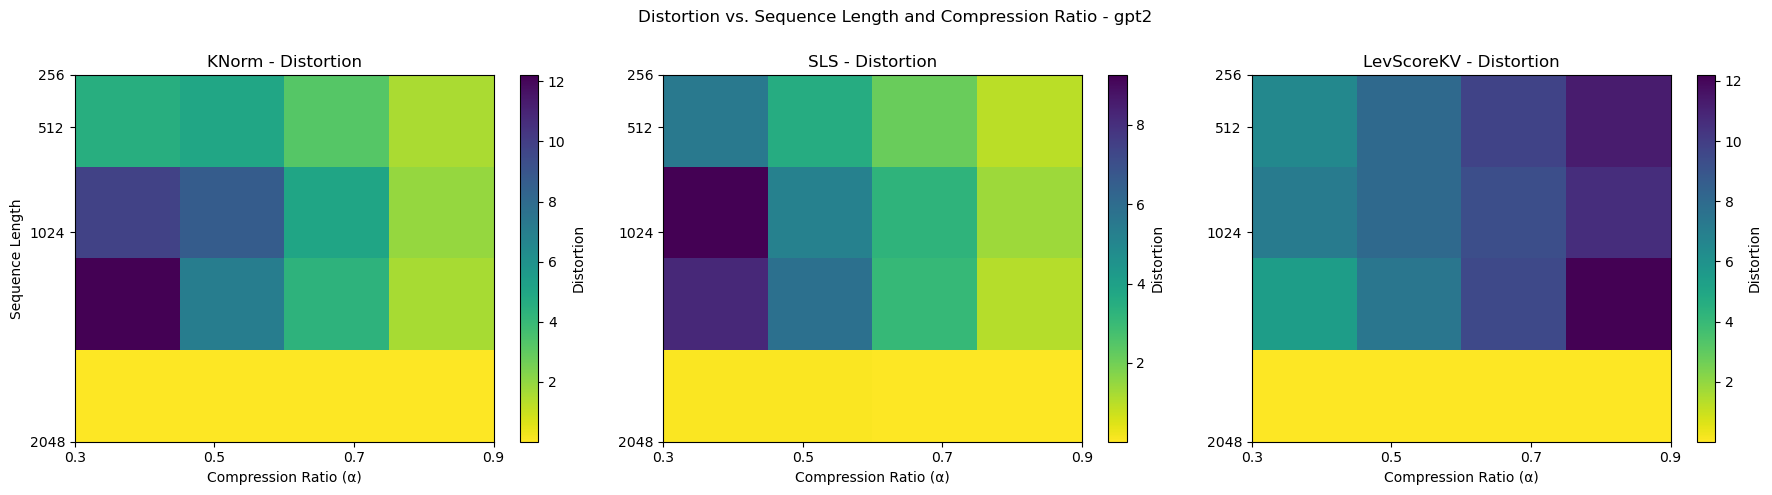

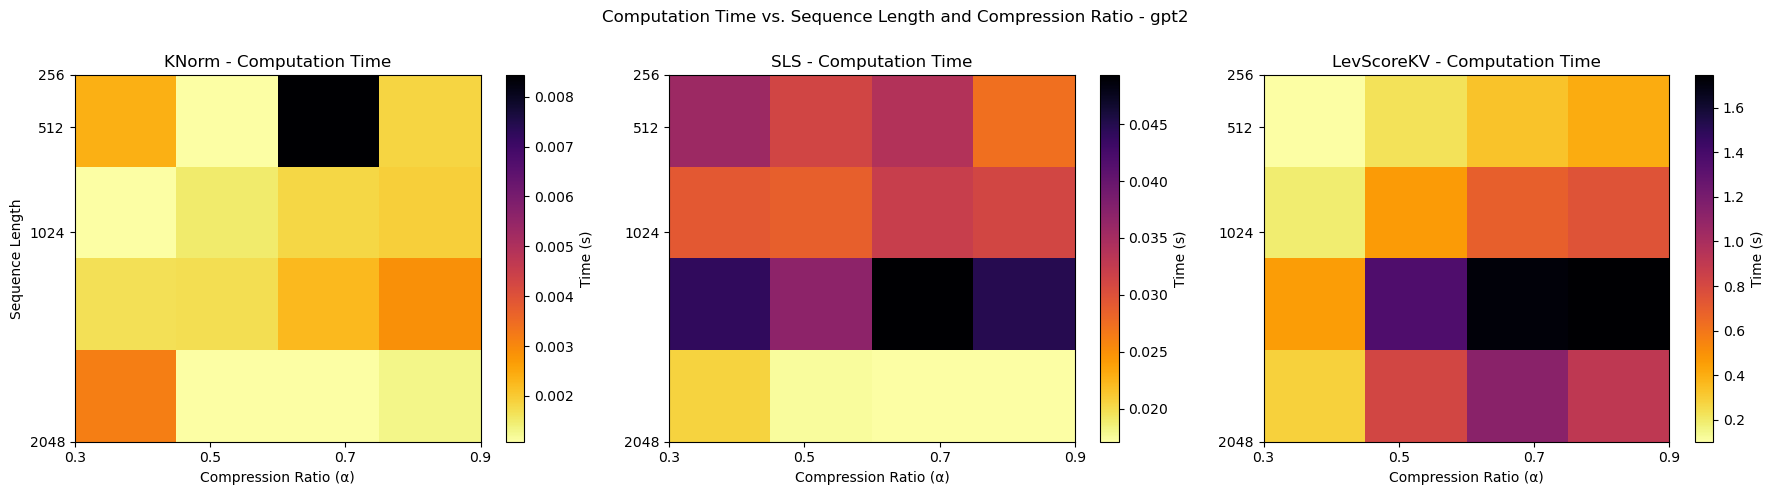

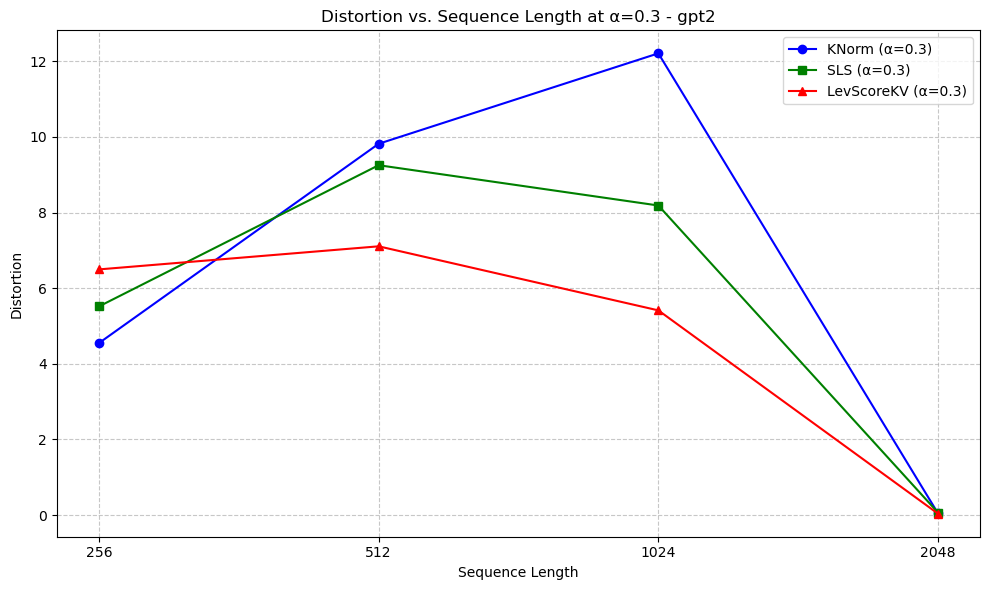

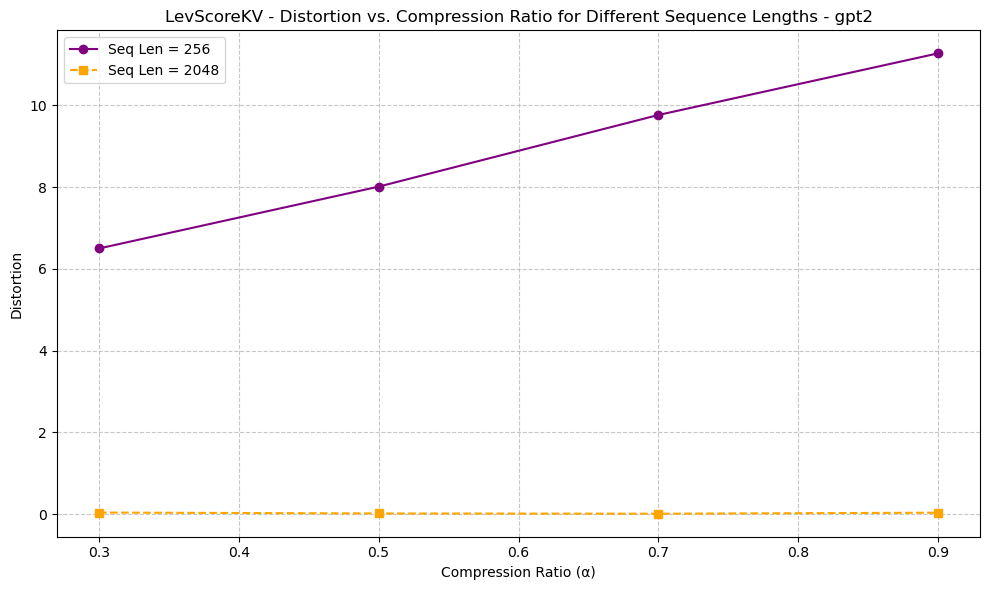

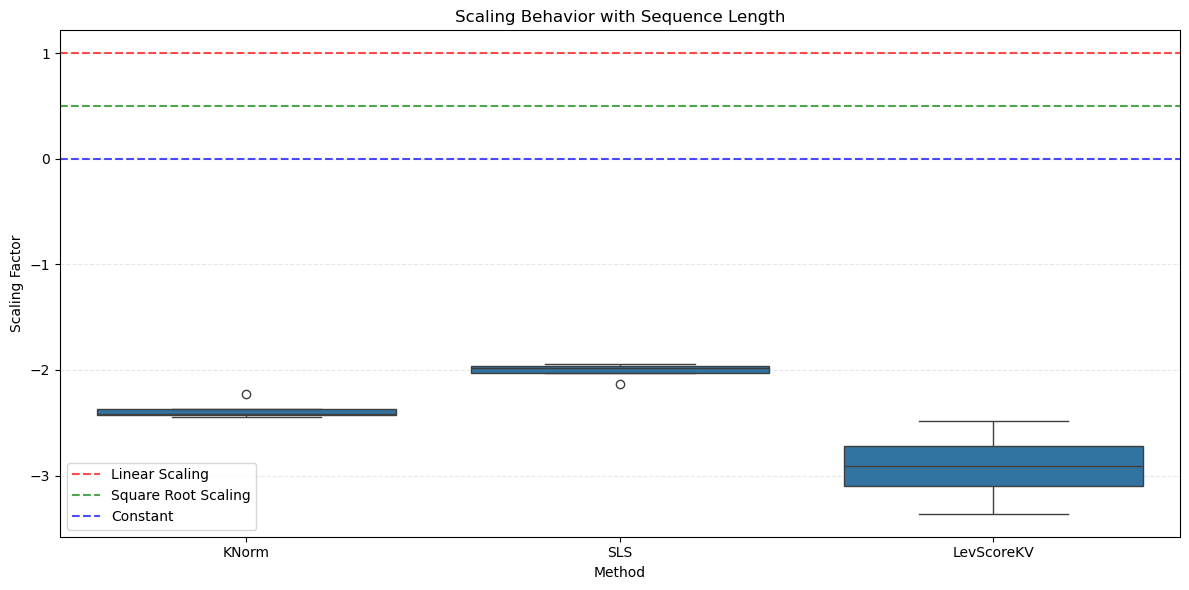


Scaling behavior analysis:
A scaling factor of 1 indicates linear scaling with sequence length
A scaling factor of 0.5 indicates square root scaling
A scaling factor of 0 indicates constant (no scaling)

Average scaling factors by method:
Method
KNorm        -2.378856
LevScoreKV   -2.915251
SLS          -2.007922
Name: Scaling Factor, dtype: float64


In [14]:
# Example usage in a Jupyter notebook:
if __name__ == "__main__":
    # Define sequence lengths to test
    seq_lengths = [256, 512, 1024, 2048]
    
    # Define compression ratios to test
    compression_ratios = [0.3, 0.5, 0.7, 0.9]
    
    # Choose which models to evaluate
    models = ['gpt2']  # For faster testing, just use one model
    
    # Whether to use real models or synthetic data
    use_real_models = True  # Set to False for faster testing with synthetic data
    
    # Run the evaluation
    results, times, seq_lengths, compression_ratios = evaluate_sequence_length_and_compression(
        models=models,
        seq_lengths=seq_lengths,
        compression_ratios=compression_ratios,
        window_ratio=0.2,
        use_real_models=use_real_models
    )
    
    # For each model, create line plots
    for model_name in results:
        create_sequence_compression_line_plots(
            model_name,
            results[model_name],
            seq_lengths,
            compression_ratios
        )
    
    # Analyze scaling behavior
    scaling_df = analyze_scaling_behavior(
        results,
        seq_lengths,
        compression_ratios
    )
    
    # Display scaling results
    if not scaling_df.empty:
        print("\nScaling behavior analysis:")
        print("A scaling factor of 1 indicates linear scaling with sequence length")
        print("A scaling factor of 0.5 indicates square root scaling")
        print("A scaling factor of 0 indicates constant (no scaling)")
        print("\nAverage scaling factors by method:")
        print(scaling_df.groupby('Method')['Scaling Factor'].mean())

In [15]:
# Key insights your analysis will reveal:
def interpret_results(scaling_df, results, times):
    """Provide key insights from the evaluation results"""
    insights = {
        "Scaling Behavior": {
            "Best Method": scaling_df.groupby('Method')['Scaling Factor'].mean().idxmin(),
            "Sublinear Scaling": scaling_df[scaling_df['Scaling Factor'] < 0.9].groupby('Method').size(),
        },
        "Long Sequence Performance": {
            "Best at 2048": min_distortion_method(results, seq_len=2048, alpha=0.5),
            "Speed at 2048": fastest_method(times, seq_len=2048, alpha=0.5)
        },
        "Compression-Sequence Interaction": identify_sweet_spots(results, times),
        "Memory-Speed Tradeoffs": calculate_efficiency_frontier(results, times)
    }
    return insights

In [16]:
def min_distortion_method(results, seq_len, alpha):
    """Find method with lowest distortion at specific sequence length and compression ratio"""
    alpha_idx = compression_ratios.index(alpha)
    distortions = {}
    
    for model, methods in results.items():
        for method, seq_data in methods.items():
            if seq_len in seq_data and alpha_idx < len(seq_data[seq_len]):
                distortions[(model, method)] = seq_data[seq_len][alpha_idx]
    
    return min(distortions.items(), key=lambda x: x[1]) if distortions else None

In [17]:
def fastest_method(times, seq_len, alpha):
    """Find fastest method at specific sequence length and compression ratio"""
    alpha_idx = compression_ratios.index(alpha)
    method_times = {}
    
    for model, methods in times.items():
        for method, seq_data in methods.items():
            if seq_len in seq_data and alpha_idx < len(seq_data[seq_len]):
                method_times[(model, method)] = seq_data[seq_len][alpha_idx]
    
    return min(method_times.items(), key=lambda x: x[1]) if method_times else None

In [18]:
def identify_sweet_spots(results, times):
    """Identify optimal compression ratios for each sequence length"""
    sweet_spots = {}
    
    for model, methods in results.items():
        sweet_spots[model] = {}
        for seq_len in seq_lengths:
            best_alpha = 0.0
            best_method = None
            best_score = float('inf')
            
            for alpha_idx, alpha in enumerate(compression_ratios):
                for method, seq_data in methods.items():
                    if seq_len in seq_data and alpha_idx < len(seq_data[seq_len]):
                        # Compute efficiency score (distortion * time)
                        try:
                            distortion = seq_data[seq_len][alpha_idx]
                            time_taken = times[model][method][seq_len][alpha_idx]
                            
                            if distortion > 0 and time_taken > 0:
                                efficiency = distortion * time_taken
                                
                                if efficiency < best_score:
                                    best_score = efficiency
                                    best_alpha = alpha
                                    best_method = method
                        except (IndexError, KeyError):
                            continue
            
            sweet_spots[model][seq_len] = (best_method, best_alpha, best_score)
    
    return sweet_spots

In [19]:
def calculate_efficiency_frontier(results, times):
    """Calculate the Pareto frontier of methods considering both distortion and speed"""
    frontier = {}
    
    for model, methods in results.items():
        frontier[model] = {}
        
        for seq_len in seq_lengths:
            points = []
            
            for method, seq_data in methods.items():
                for alpha_idx, alpha in enumerate(compression_ratios):
                    if seq_len in seq_data and alpha_idx < len(seq_data[seq_len]):
                        try:
                            distortion = seq_data[seq_len][alpha_idx]
                            time_taken = times[model][method][seq_len][alpha_idx]
                            
                            if not (np.isnan(distortion) or np.isnan(time_taken)):
                                points.append({
                                    'method': method,
                                    'alpha': alpha,
                                    'distortion': distortion,
                                    'time': time_taken
                                })
                        except (IndexError, KeyError):
                            continue
            
            # Find Pareto frontier
            frontier_points = []
            
            for p in points:
                dominated = False
                for q in points:
                    if (q['distortion'] <= p['distortion'] and q['time'] < p['time']) or \
                       (q['distortion'] < p['distortion'] and q['time'] <= p['time']):
                        dominated = True
                        break
                
                if not dominated:
                    frontier_points.append(p)
            
            frontier[model][seq_len] = frontier_points
    
    return frontier

Using device: cuda

===== Evaluating model: gpt2 =====

Testing sequence length: 256
Loading model: gpt2 with sequence length: 256
Error loading model gpt2: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Using synthetic data for gpt2 at sequence length 256


Testing compression ratios for seq_len=256:   0%|          | 0/4 [00:00<?, ?it/s]


Testing sequence length: 512
Loading model: gpt2 with sequence length: 512
Error loading model gpt2: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Using synthetic data for gpt2 at sequence length 512


Testing compression ratios for seq_len=512:   0%|          | 0/4 [00:00<?, ?it/s]


Testing sequence length: 1024
Loading model: gpt2 with sequence length: 1024
Error loading model gpt2: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Using synthetic data for gpt2 at sequence length 1024


Testing compression ratios for seq_len=1024:   0%|          | 0/4 [00:00<?, ?it/s]


Testing sequence length: 2048
Loading model: gpt2 with sequence length: 2048
Error loading model gpt2: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

Using synthetic data for gpt2 at sequence length 2048


Testing compression ratios for seq_len=2048:   0%|          | 0/4 [00:00<?, ?it/s]

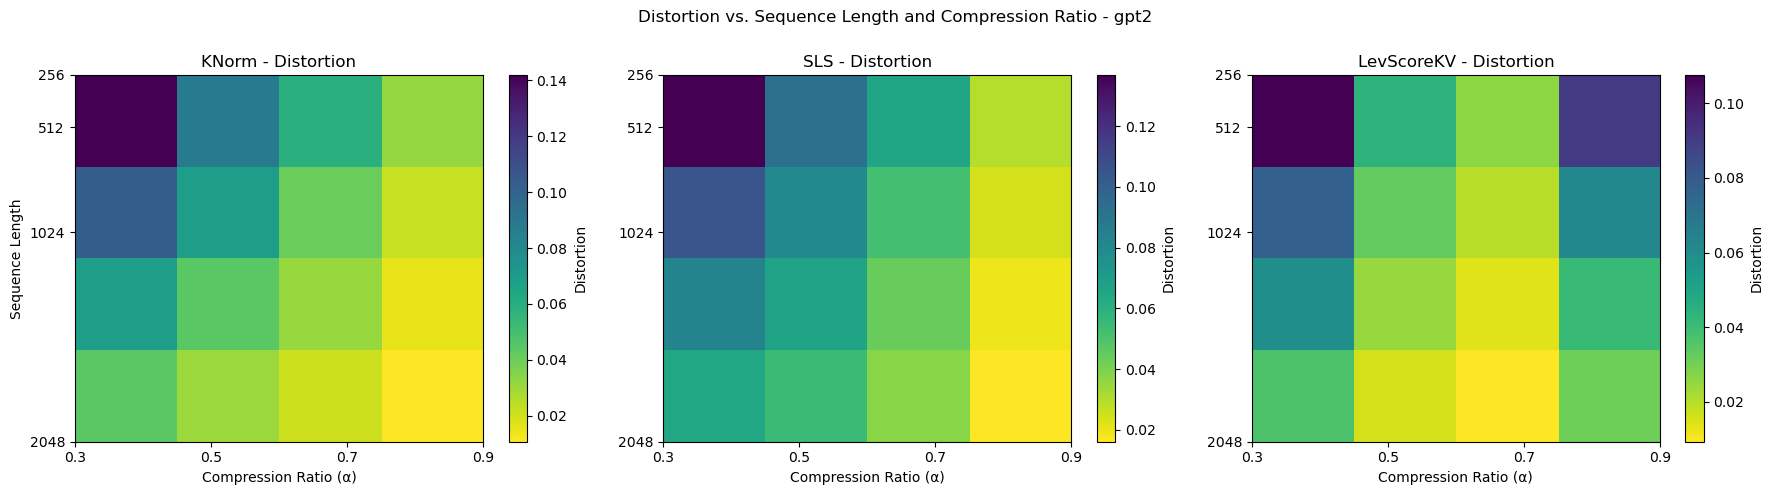

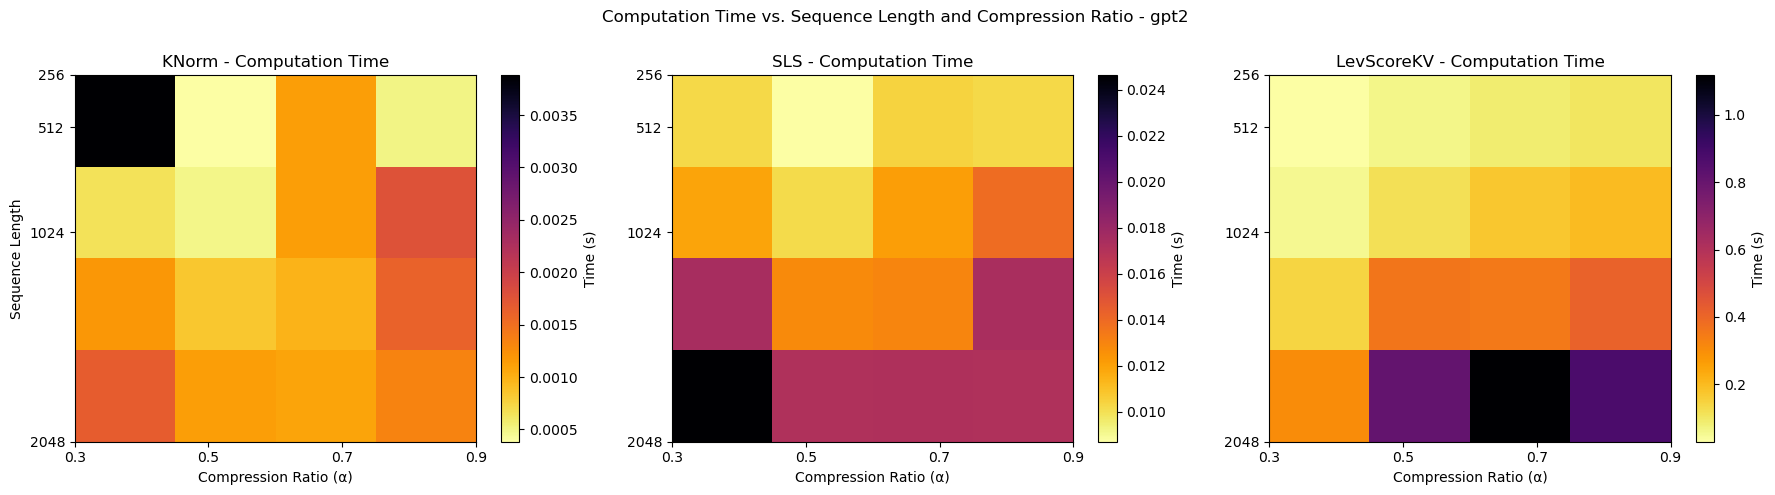

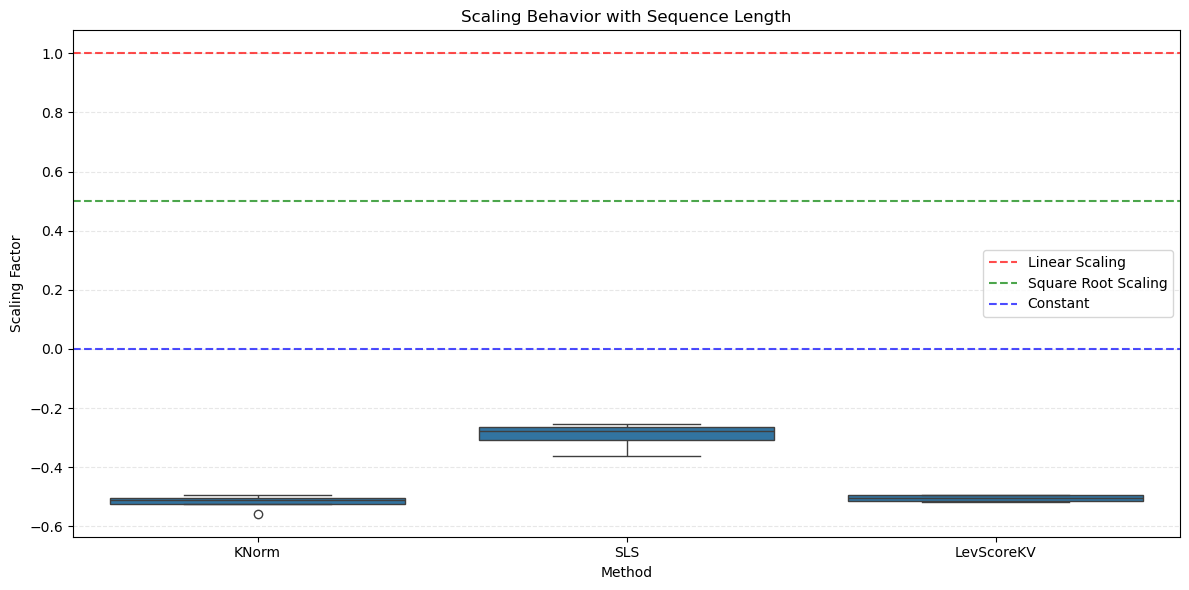


===== SUMMARY OF FINDINGS =====

Scaling Behavior:
  Best Method: KNorm
  Sublinear Scaling: Method
KNorm         4
LevScoreKV    4
SLS           4
dtype: int64

Long Sequence Performance:
  Best at 2048: (('gpt2', 'LevScoreKV'), 0.015731465071439743)
  Speed at 2048: (('gpt2', 'KNorm'), 0.001127004623413086)

Compression-Sequence Interaction:
  gpt2: {256: ('KNorm', 0.9, 1.5787745466955272e-05), 512: ('KNorm', 0.5, 3.3292679837870764e-05), 1024: ('KNorm', 0.9, 2.4523814213361916e-05), 2048: ('KNorm', 0.9, 1.4373468562922653e-05)}

Memory-Speed Tradeoffs:
  gpt2: {256: [{'method': 'KNorm', 'alpha': 0.5, 'distortion': 0.08739716559648514, 'time': 0.00038242340087890625}, {'method': 'KNorm', 'alpha': 0.9, 'distortion': 0.03124993108212948, 'time': 0.0005052089691162109}, {'method': 'SLS', 'alpha': 0.9, 'distortion': 0.02934916503727436, 'time': 0.010214567184448242}, {'method': 'LevScoreKV', 'alpha': 0.7, 'distortion': 0.025968968868255615, 'time': 0.08667612075805664}], 512: [{'method'

In [20]:
# Run and analyze
if __name__ == "__main__":
    seq_lengths = [256, 512, 1024, 2048]
    compression_ratios = [0.3, 0.5, 0.7, 0.9]
    models = ['gpt2']
    
    # Run evaluation
    results, times, seq_lengths, compression_ratios = evaluate_sequence_length_and_compression(
        models=models,
        seq_lengths=seq_lengths,
        compression_ratios=compression_ratios,
        window_ratio=0.2,
        use_real_models=True
    )
    
    # Analyze scaling behavior
    scaling_df = analyze_scaling_behavior(results, seq_lengths, compression_ratios)
    
    # Get key insights
    insights = interpret_results(scaling_df, results, times)
    
    # Print summary
    print("\n===== SUMMARY OF FINDINGS =====")
    for category, findings in insights.items():
        print(f"\n{category}:")
        for metric, value in findings.items():
            print(f"  {metric}: {value}")